#Bike Sharing, Data Cleaning, Pre processing and visualization

## Introduction

In this test task I have an opportunity to demonstrate my skills on Data Science from various angles - processing data, analyzing and vizalizing it, finding insights, applying predictive techniques and explaining my reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below,  necessary code and comment 

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepared a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze is included as part of submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset . Here is an available mirror in case the above website is down: https://data.world/uci/bike-sharing-dataset
3. Load the data into Python runtime as Pandas dataframe.
4. Split the data into two parts. One dataset containing the last 15 days and one dataset with the rest.

In [ ]:
# try to get the bare minimum to get a new conda env working
conda_path = ''
try:
    conda_path = !which conda
finally:
    print('')

if (len(conda_path) == 0):
    print('installing miniconda')
    !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
    !conda update conda -y -q
    !source /usr/local/etc/profile.d/conda.sh
    !conda init 
    !conda install -n root _license -y -q
else:
    print('found miniconda')

conda_envs = !conda env list
res = [i for i in conda_envs if 'BikeSharingenv' in i]
if (len(res) == 0):
    print('not found BikeSharingenv env', len(res))
    !conda create -y -q --name BikeSharingenv python=3.6
else:
    print('found BikeSharingenv env', len(res))


installing miniconda
--2021-08-01 09:20:03--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2021-08-01 09:20:03--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   177MB/s    in 0.3s    

2021-08-01 09:20:04 (177 MB/s) - ‘Minic

In [ ]:
%%bash
source activate BikeSharingenv

python
import sys
# maybe only need this the first time we run this notebook
sys.path.append('/usr/local/lib/python3.6/site-packages')

print("Python version")
print(sys.version)

Python version
3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


# import Libraries

In [1]:
# data visualisation and manipulation
import os
import pylab
import calendar
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import zipfile
from six.moves import urllib
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import math
from scipy import stats
from datetime import datetime
#import rfpimp
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# sets matplotlib to inline and displays graphs below the corressponding cell.
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)


In [2]:
DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/"
BIKE_PATH = os.path.join("sample_data", "bike_sharing")
BIKE_URL = DOWNLOAD_ROOT + "Bike-Sharing-Dataset.zip"

In [3]:
def fetch_housing_data(bike_url=BIKE_URL, bike_path=BIKE_PATH):
 if not os.path.isdir(bike_path):
   os.makedirs(bike_path)
 tgz_path = os.path.join(bike_path, "Bike-Sharing-Dataset.zip")
 urllib.request.urlretrieve(bike_url, tgz_path)
 housing_tgz = zipfile.ZipFile(tgz_path,'r')
 housing_tgz.extractall()
 housing_tgz.close()


In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(bike_path=BIKE_PATH):
  csv_path = os.path.join(bike_path, "day.csv")
  return pd.read_csv(csv_path)

In [2]:
rides = pd.read_csv('day.csv')
rides[:2]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801


## Part 2 - Data Processing and Analysis

**Tasks:**
1. Performing all needed steps to load and clean the data. 
2. Let's Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Finding the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Vizalizing the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)

In [3]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [4]:
rides.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
rides.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


NOW WE CAN EXPLORE OUR FEATURES. FIRST LETS EXPLORE THE DISTRIBUTION OF VARIOUS DISCRETE FEATURES LIKE weather , season etc..

In [6]:
rides["season_cat"] = rides.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
rides["holiday_cat"] = rides.holiday.map({1: "Holiday", 0 : "Non Holiday"})
rides["workingday_cat"] = rides.workingday.map({1: "Working Day", 0 : "Non Working Day"})
rides["weather"] = rides.weathersit.map({1: "Working Day", 0 : "Non Working Day"})
rides["weather"] = rides.weathersit.map({1: " Clear, Few clouds, Partly cloudy ",\
                                        2 : " Cloudy, Mist or Broken clouds, Mist with Few clouds ", \
                                        3 : " Light Snow, Light Rain with Thunderstorm", \
                                        4 :" Heavy Rain, Ice Pallets, Thunderstorm,Snow with Fog " })

In [7]:
rides[:2]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_cat,holiday_cat,workingday_cat,weather
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,Spring,Non Holiday,Non Working Day,"Cloudy, Mist or Broken clouds, Mist with Few ..."
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,Spring,Non Holiday,Non Working Day,"Cloudy, Mist or Broken clouds, Mist with Few ..."


In [8]:
rides.season_cat.value_counts()

Fall      188
Summer    184
Spring    181
Winter    178
Name: season_cat, dtype: int64

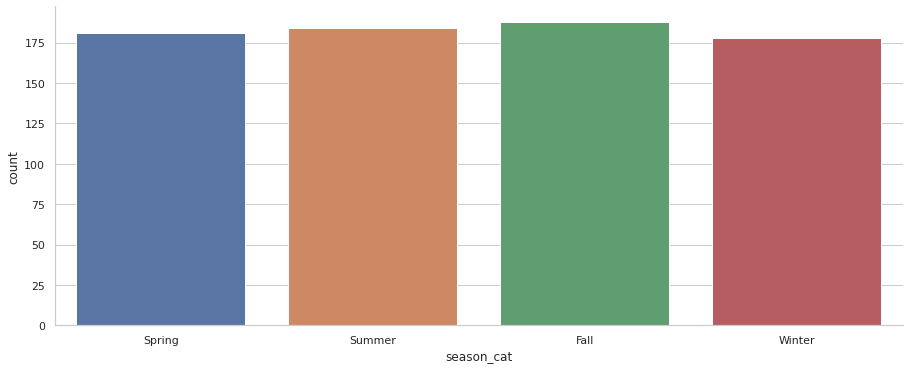

In [9]:
sns.factorplot(x='season_cat',data=rides,kind='count',size=5,aspect=2.5)

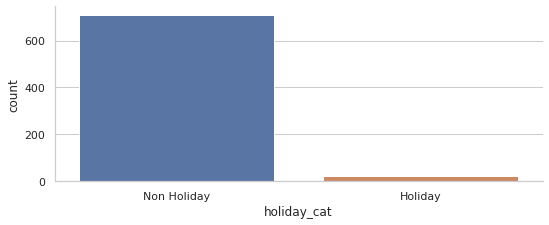

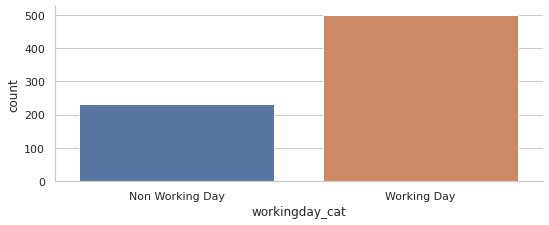

In [10]:
sns.factorplot(x='holiday_cat',data=rides,kind='count',size=3,aspect=2.5)
sns.factorplot(x='workingday_cat',data=rides,kind='count',size=3,aspect=2.5)

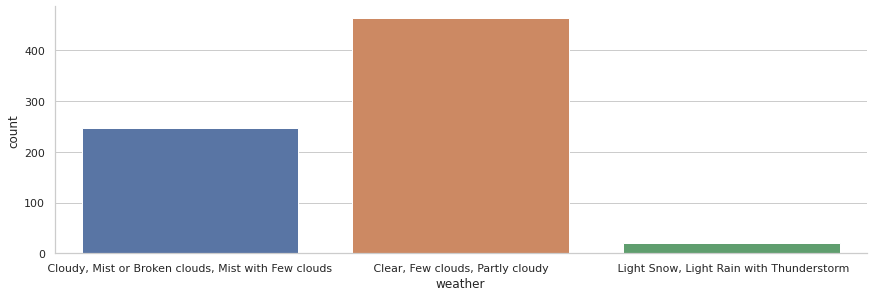

In [11]:
sns.factorplot(x='weather',data=rides,kind='count',size=4,aspect=3)  
# 1-> spring
# 2-> summer
# 3-> fall
# 4-> winter

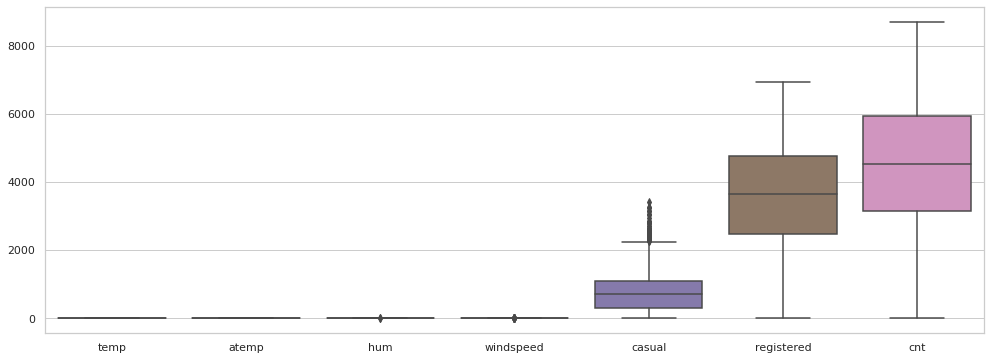

In [12]:
# for better data understanding let's visualize.
sns.boxplot(data=rides[['temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']])
fig=plt.gcf()
fig.set_size_inches(15,6)

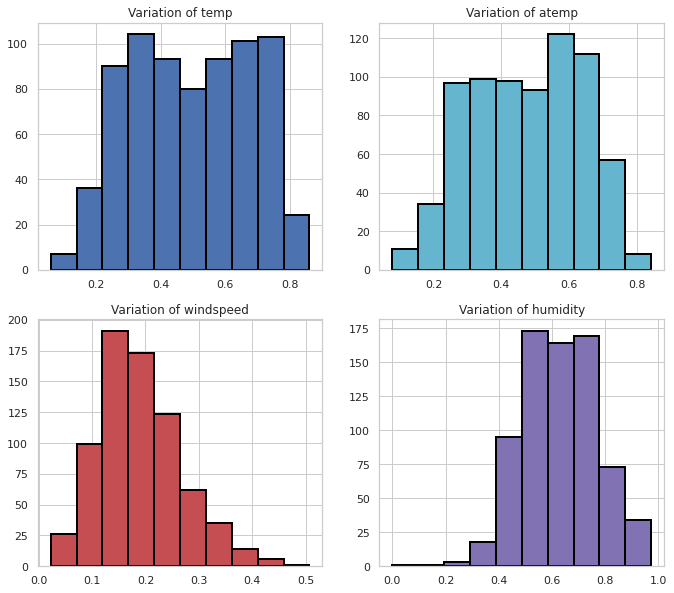

In [13]:
# let's visulaize using histograms for all the continuous variables.
rides.temp.unique()
fig,axes=plt.subplots(2,2)
axes[0,0].hist(x="temp",data=rides,edgecolor="black",linewidth=2,color='b')
axes[0,0].set_title("Variation of temp")
axes[0,1].hist(x="atemp",data=rides,edgecolor="black",linewidth=2,color='c')
axes[0,1].set_title("Variation of atemp")
axes[1,0].hist(x="windspeed",data=rides,edgecolor="black",linewidth=2,color='r')
axes[1,0].set_title("Variation of windspeed")
axes[1,1].hist(x="hum",data=rides,edgecolor="black",linewidth=2,color='m')
axes[1,1].set_title("Variation of humidity")
fig.set_size_inches(10,10)

WE HAVE SEEN DISTRIBUTION OF VARIOUS DISCRETE AS WELL AS CONTINUOUS VARIABLES WE CAN SEE THE INTERREALTION B/W THEM USING A HEAT MAP

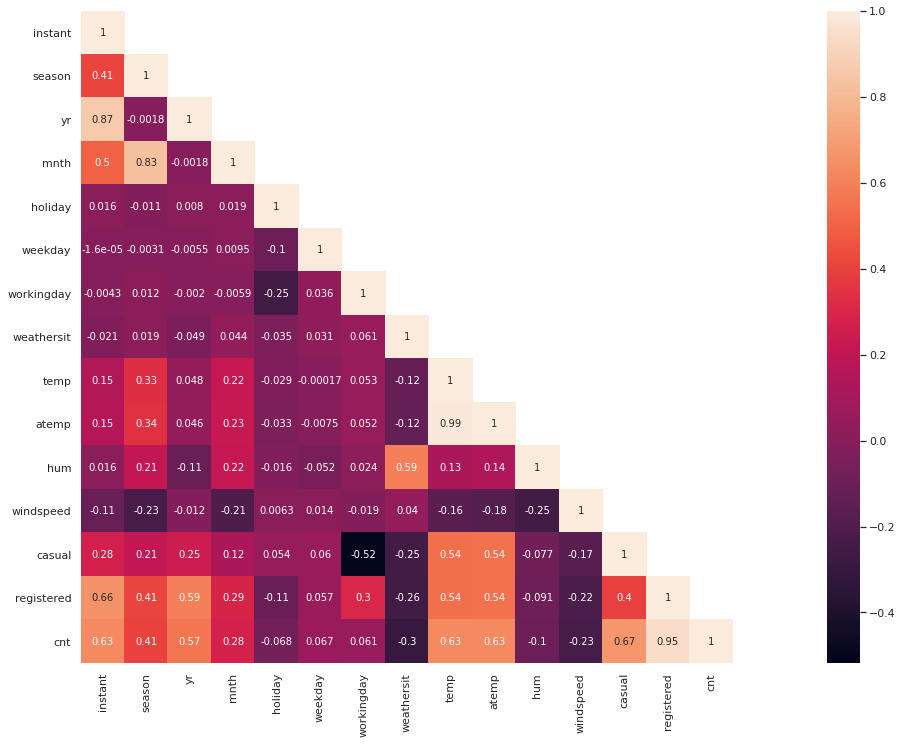

In [14]:
#corelation matrix.
cor_mat= rides[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

1. temp and atemp are highly related as expected.
2. humidity is inversely related to count as expected as the weather is humid people will not like to travel on a bike
3. casual and working day are highly inversely related as expected
4. count and holiday are highly inversely related 
5. temp(or atemp) highly effects the count
6. weather and count are highly inversely related, because as weather increases from (1 to 4) implies that weather is getting more worse and so lesser people will rent bikes.
7. registered/casual and count are highly related which indicates that most of the bikes that are rented are registered






In [15]:
print('the maximum number of bicycles nmax that was needed in any one day {}'.format(max(np.ceil(rides['cnt']/12))))

the maximum number of bicycles nmax that was needed in any one day 727.0


In [16]:
rides['Bicycle_nmax_prday'] = np.ceil((rides['cnt']/12))
rides['Bicycle_95_prday'] = np.ceil((rides['cnt']/12)*(.95))
rides['Bicycle_80_prday'] = np.ceil((rides['cnt']/12)*(.80))

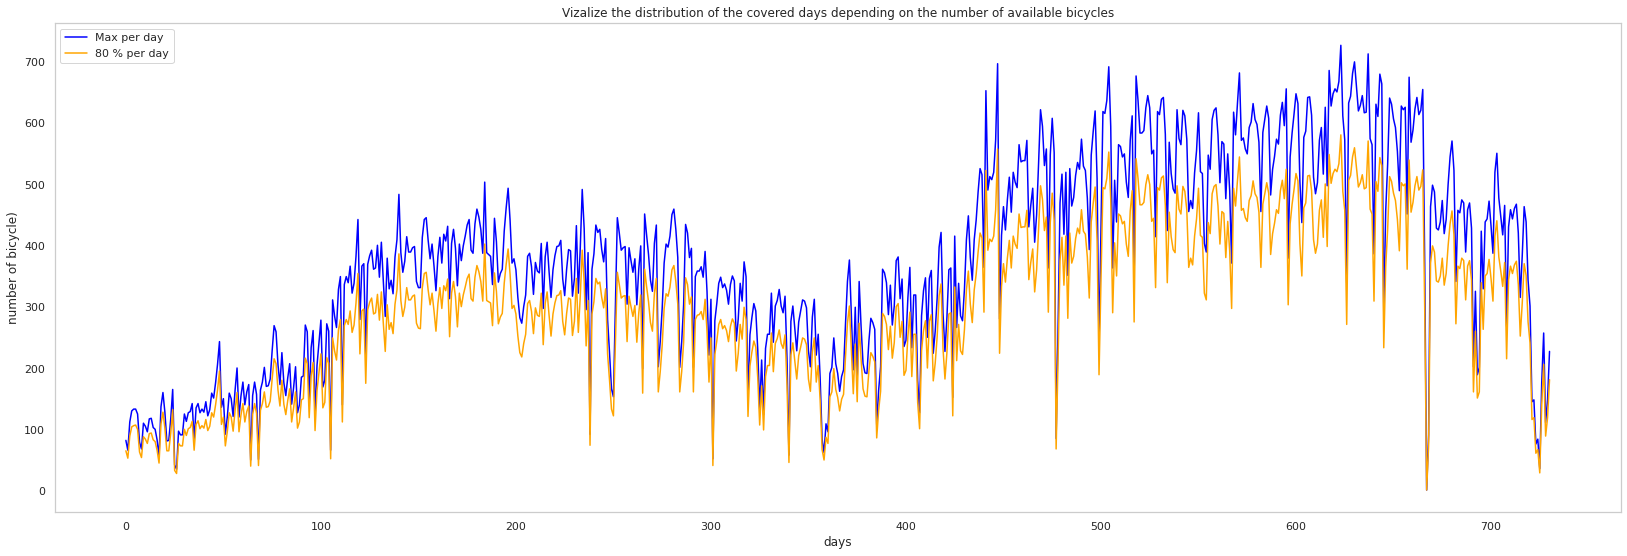

In [17]:
plt.figure(figsize=(25,9))
plt.title('Vizalize the distribution of the covered days depending on the number of available bicycles')

ax1 = rides.Bicycle_nmax_prday.plot(color='blue', grid=False, label='Max per day')
ax2 = rides.Bicycle_80_prday.plot(color='orange', grid=False,  label='80 % per day')

plt.legend(loc="upper left")

plt.xlabel("days")
plt.ylabel("number of bicycle)")
plt.show()

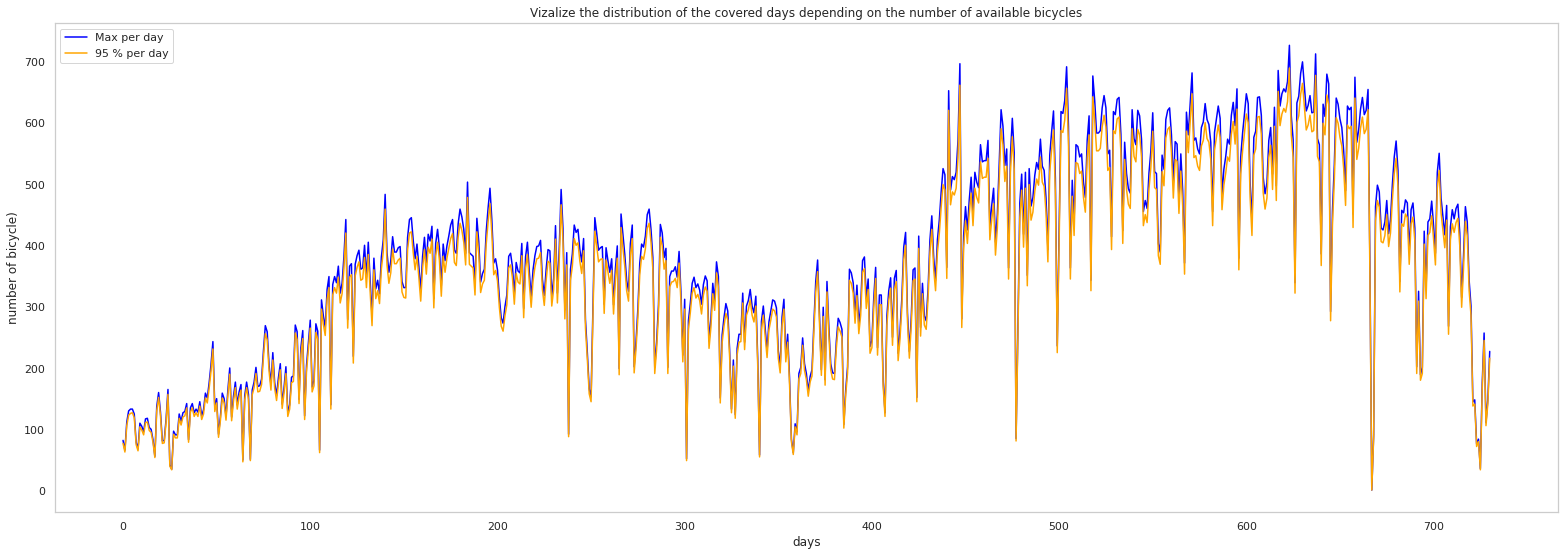

In [18]:
plt.figure(figsize=(24,9))
plt.title('Vizalize the distribution of the covered days depending on the number of available bicycles')

ax1 = rides.Bicycle_nmax_prday.plot(color='blue', grid=False, label='Max per day')
ax2 = rides.Bicycle_95_prday.plot(color='orange', grid=False,  label='95 % per day')

plt.legend(loc="upper left")

plt.xlabel("days")
plt.ylabel("number of bicycle)")
plt.show()

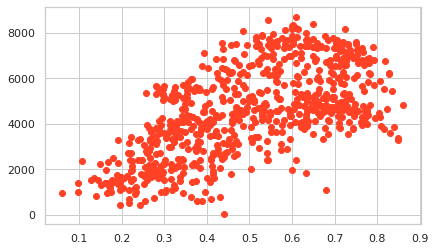

In [19]:
plt.scatter(x="temp",y="cnt",data=rides,color='#ff4125')
#sns.factorplot(x="temp",y="cnt",data=rides,kind='bar')

In [20]:
hours = pd.read_csv('hour.csv')
hours[:2]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


In [21]:
hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


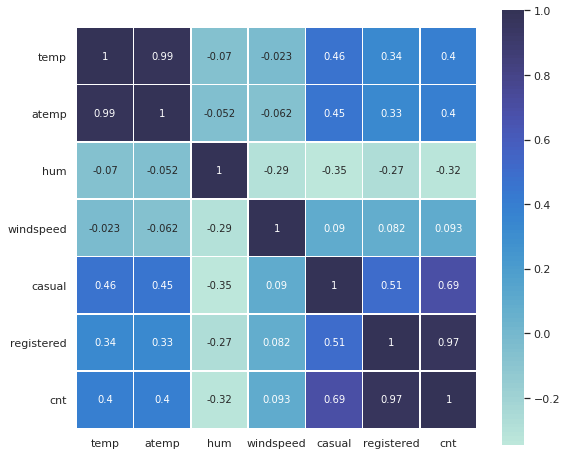

In [22]:
corr = hours[['temp','atemp','hum', 'windspeed','casual', 'registered',
                 'cnt']].corr()
f,axes = plt.subplots(1,1,figsize = (8,8))
sns.heatmap(corr,square=True,annot = True,linewidth = .5,center = 1.4,ax = axes)

Line plot for all continuous values in file

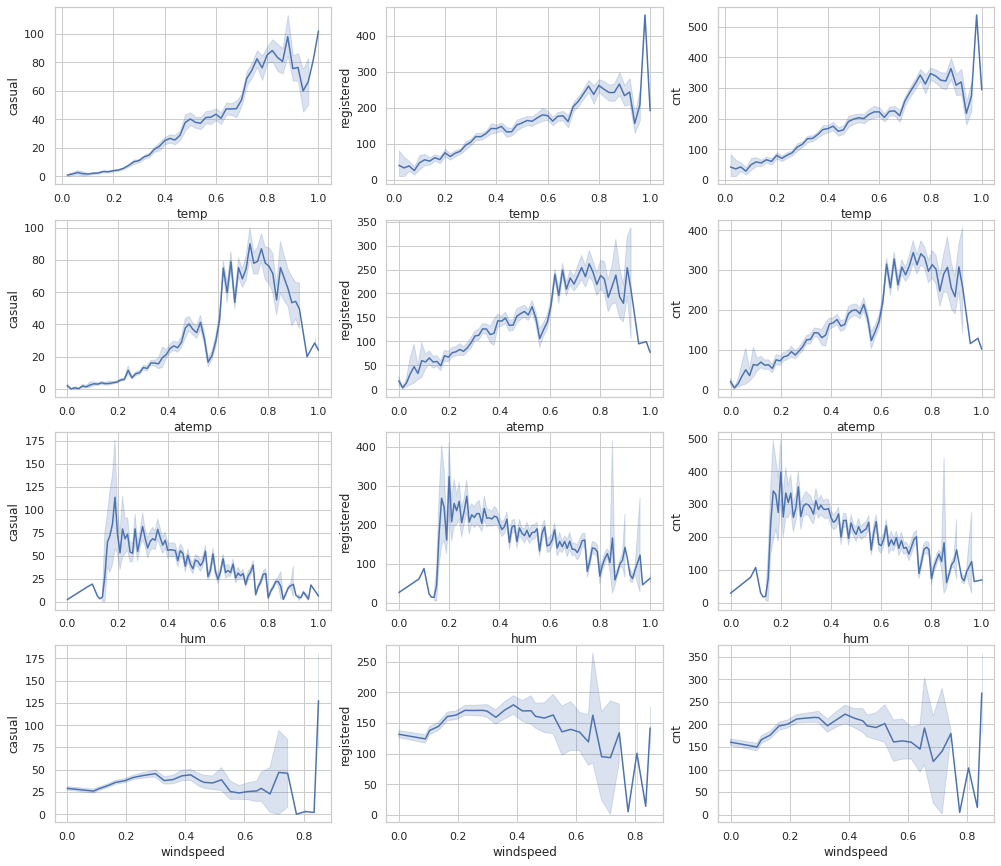

In [23]:
y = ['casual','registered','cnt']
list_continuous = ['temp','atemp','hum','windspeed']
n=3
s= 15
f,axes = plt.subplots(4,3,figsize = (s,s))
counter = 0
for i in list_continuous:
    for j in y:
        sns.lineplot(x = i , y = j , data  = hours, ax = axes[counter//n][counter%n])
        counter+=1

conclusions drawn are:
We can see that temp and atemp have a very strong positive correlation therefore we can use drop atemp as a variable without any loss of information.

We can infer from the correlaton matrix and lineplots that windspeed has no significant correlation with the casual,registered or count which we wish to predict so we can remove that

In [24]:
hours['dteday'] = pd.DatetimeIndex(hours['dteday']).date
hours.set_index(hours['dteday'])[:4]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,,
2011-01-01,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13


In [25]:
hours["month"] = hours.mnth.map({1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})
hours['weekday_cat'] =  hours.weekday.map({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"})
hours['season_cat'] = hours.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
hours['weather_cat'] = hours.weathersit.map({1: "Clear",\
                                        2 : "Mist with Clouds", \
                                        3 : "Light Snow,Rain,Thunderstorm", \
                                        4 :"Rain,Ice Pallets,Snow" })

In [26]:
a = []
for i in hours.index:
    a.append('Total Count : '+str(hours['cnt'][i]))
hours['count_vis'] = a

In [27]:
fig = px.line(x = 'dteday', y = "cnt", data_frame = hours,color = 'hr',
              range_y = (0,1150),hover_data = ['hr','dteday','casual','registered'],
              title = 'Interactive LinePlot of the whole dataset(Hover for more details)',
              hover_name = 'count_vis', text = None,height = 670,width = 980)
fig.show()

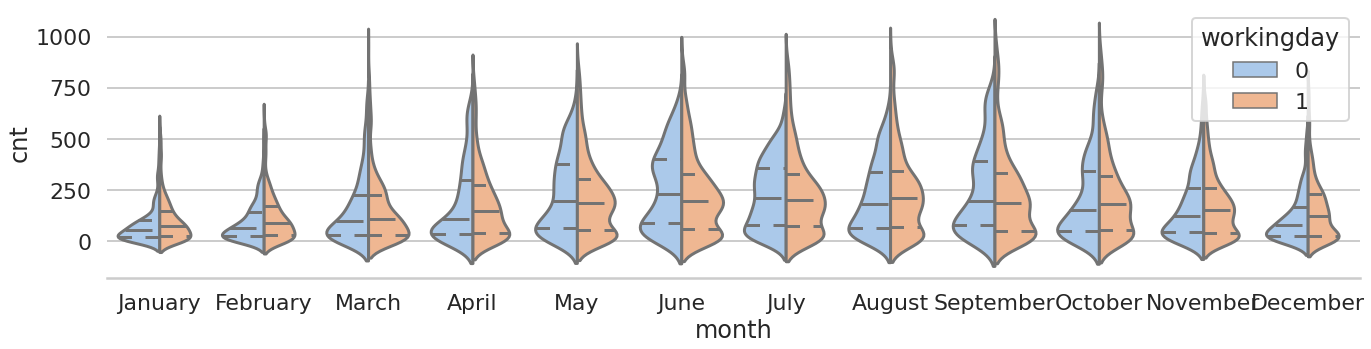

In [41]:
sns.set(rc={'figure.figsize':(20,5)})
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")
train_data2 = hours.copy()
sns.violinplot(x="month", y="cnt", hue="workingday", data=train_data2, split=True, inner="quart", )

sns.despine(left=True)


[Text(0.5, 1.0, 'total bikes shared across seasons')]

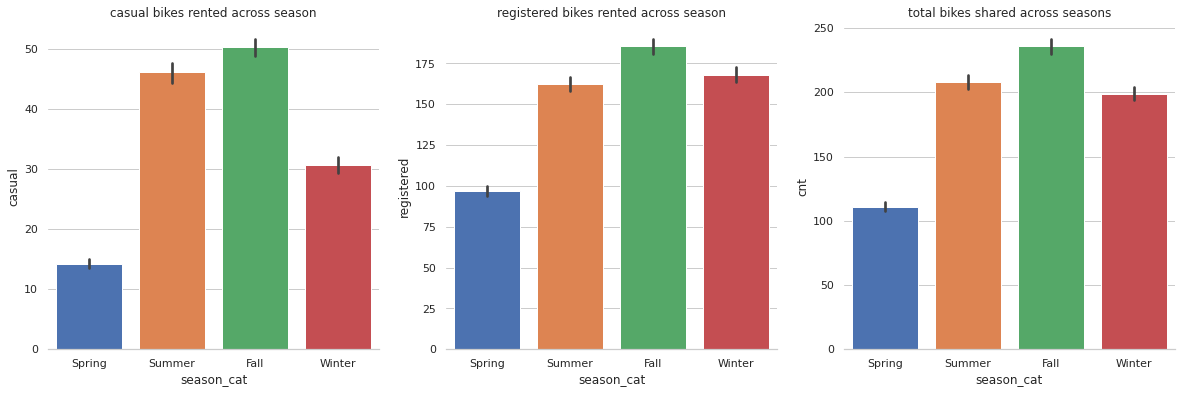

In [28]:
f,axes = plt.subplots(1,3,figsize = (18,6))
sns.despine(left = True)
x = 'season_cat'

sns.barplot(x = x , y = 'casual' , data = hours, saturation = 1, ax =  axes[0]).set(title='casual bikes rented across season')
sns.barplot(x = x , y = 'registered' , data = hours, saturation = 1, ax = axes[1]).set(title='registered bikes rented across season')
sns.barplot(x = x , y = 'cnt' , data = hours, saturation = 1, ax = axes[2]).set(title='total bikes shared across seasons')

[Text(0.5, 1.0, 'bikes rented overall on Holidays')]

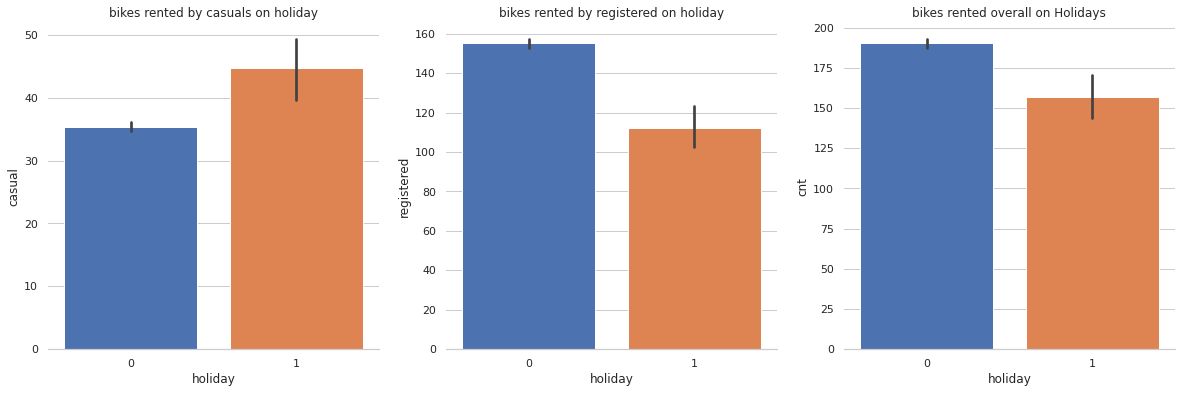

In [29]:
f,axes = plt.subplots(1,3,figsize = (18,6))
sns.despine(left = True)
x = 'holiday'

sns.barplot(x = x , y = 'casual' , data = hours, saturation = 1,ax =  axes[0]).set(title='bikes rented by casuals on holiday')
sns.barplot(x = x , y = 'registered' , data = hours, saturation = 1, ax = axes[1]).set(title='bikes rented by registered on holiday')
sns.barplot(x = x , y = 'cnt' , data = hours, saturation = 1, ax = axes[2]).set(title='bikes rented overall on Holidays')

[Text(0.5, 1.0, 'Total bikes rented on various weather conditions')]

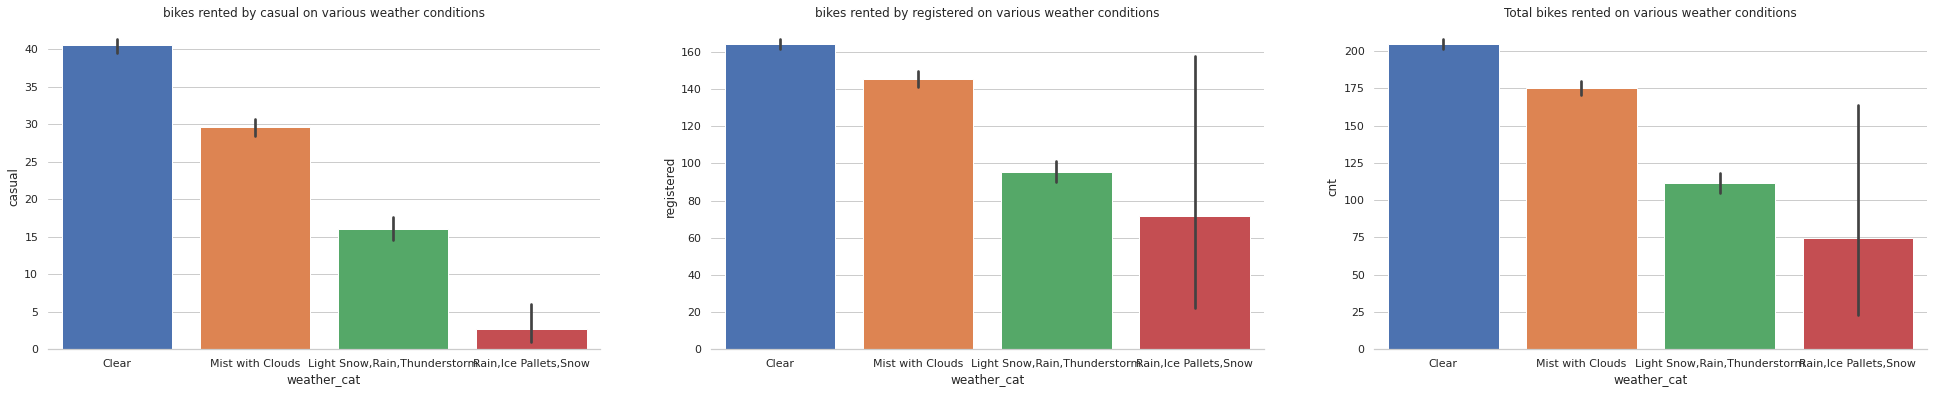

In [30]:
f,axes = plt.subplots(1,3,figsize = (30,6))
sns.despine(left = True)
x = 'weather_cat'

sns.barplot(x = x , y = 'casual' , data = hours, saturation = 1,ax =  axes[0]).set(title='bikes rented by casual on various weather conditions')
sns.barplot(x = x , y = 'registered' , data = hours, saturation = 1, ax = axes[1]).set(title='bikes rented by registered on various weather conditions')
sns.barplot(x = x , y = 'cnt' , data = hours, saturation = 1, ax = axes[2]).set(title='Total bikes rented on various weather conditions')

[Text(0.5, 1.0, 'Total bikes rented on workingday ')]

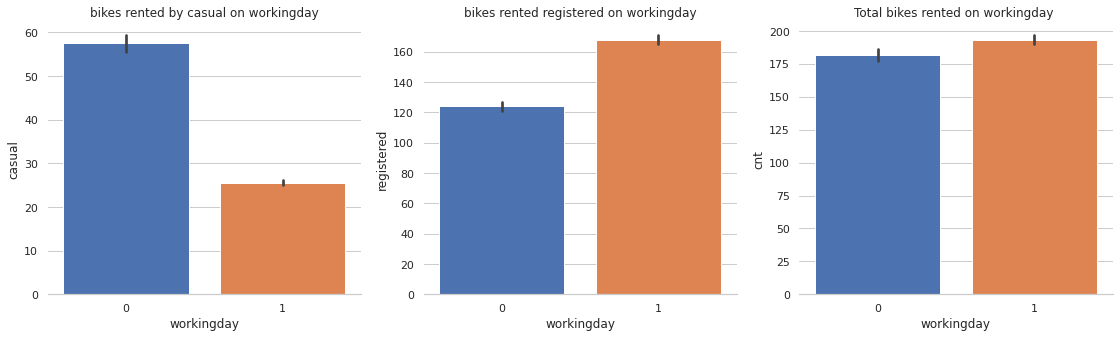

In [31]:
f,axes = plt.subplots(1,3,figsize = (17,5))
sns.despine(left = True)
x = 'workingday'

sns.barplot(x = x , y = 'casual' , data = hours, saturation = 1,ax =  axes[0]).set(title='bikes rented by casual on workingday')
sns.barplot(x = x , y = 'registered' , data = hours, saturation = 1, ax = axes[1]).set(title='bikes rented registered on workingday')
sns.barplot(x = x , y = 'cnt' , data = hours, saturation = 1, ax = axes[2]).set(title='Total bikes rented on workingday ')

[Text(0.5, 1.0, 'Total bikes rented on Hourly basis')]

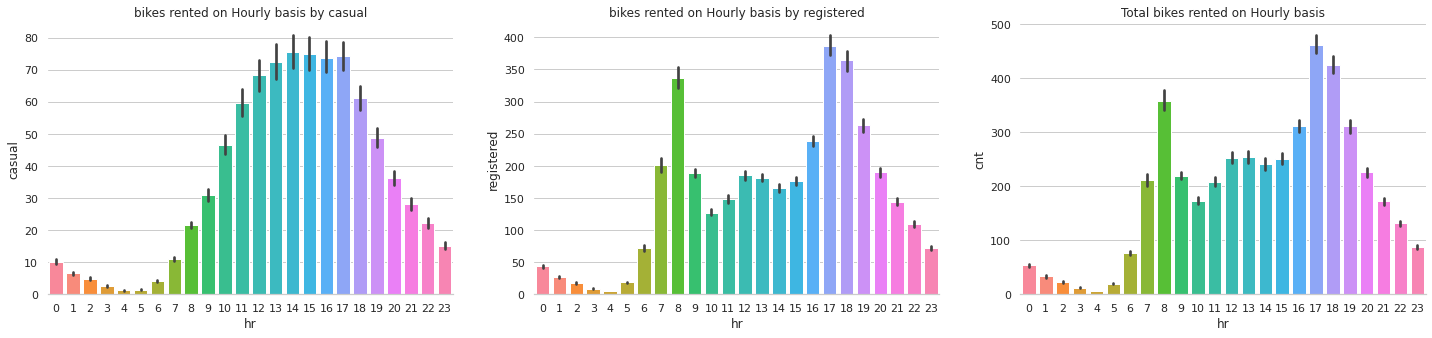

In [32]:
f,axes = plt.subplots(1,3,figsize = (22,5))
sns.despine(left = True)
x = 'hr'

sns.barplot(x = x , y = 'casual' , data = hours, saturation = 1,ax =  axes[0]).set(title='bikes rented on Hourly basis by casual')
sns.barplot(x = x , y = 'registered' , data = hours, saturation = 1, ax = axes[1]).set(title='bikes rented on Hourly basis by registered')
sns.barplot(x = x , y = 'cnt' , data = hours, saturation = 1, ax = axes[2]).set(title='Total bikes rented on Hourly basis')

[Text(0.5, 1.0, 'Total bikes rented on Yearly basis')]

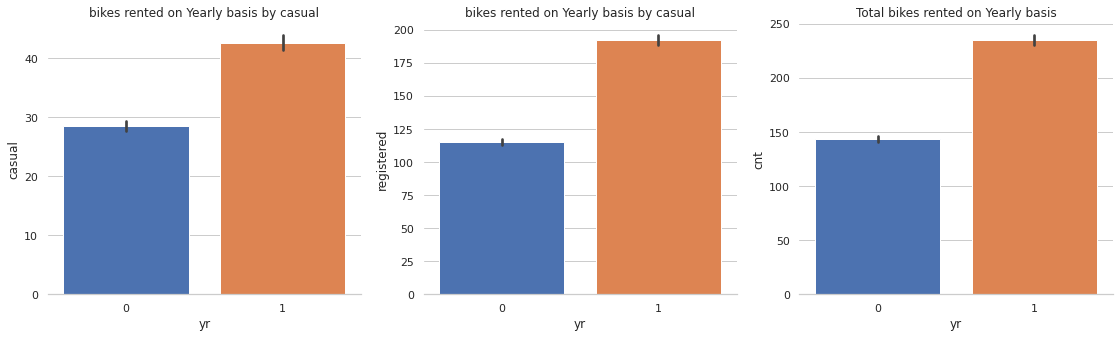

In [33]:
f,axes = plt.subplots(1,3,figsize = (17,5))
sns.despine(left = True)
x = 'yr'

sns.barplot(x = x , y = 'casual' , data = hours, saturation = 1,ax =  axes[0]).set(title='bikes rented on Yearly basis by casual')
sns.barplot(x = x , y = 'registered' , data = hours, saturation = 1, ax = axes[1]).set(title='bikes rented on Yearly basis by casual')
sns.barplot(x = x , y = 'cnt' , data = hours, saturation = 1, ax = axes[2]).set(title='Total bikes rented on Yearly basis')

We can see that overal the company made growth from the year 2011 to the year 2012

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

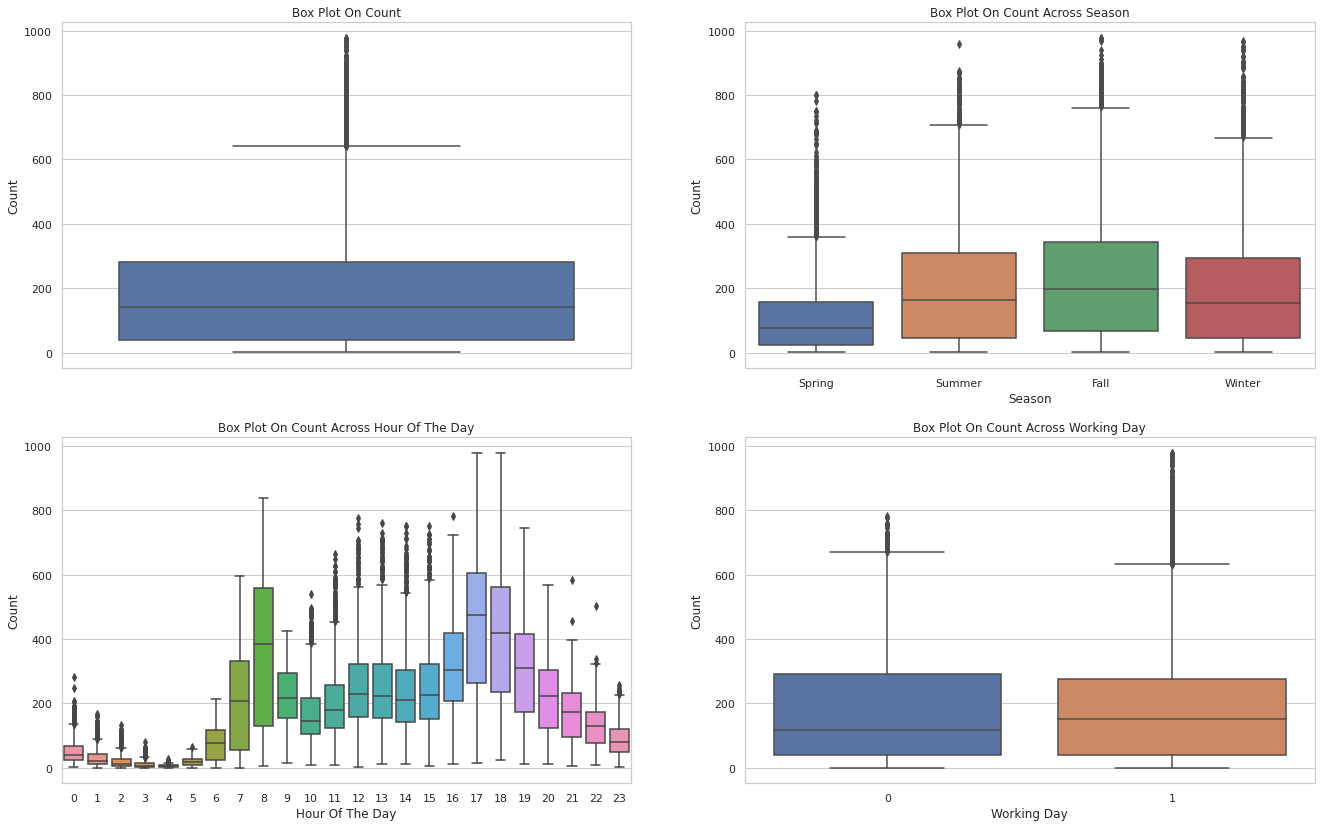

In [34]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 14)
sns.boxplot(data=hours,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=hours,y="cnt",x="season_cat",orient="v",ax=axes[0][1])
sns.boxplot(data=hours,y="cnt",x="hr",orient="v",ax=axes[1][0])
sns.boxplot(data=hours,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

"count" variable contains lot of outlier data points which skews the distribution towards right 
Spring season has got relatively lower count.The dip in median value in boxplot gives evidence for it.
The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.
Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". 

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

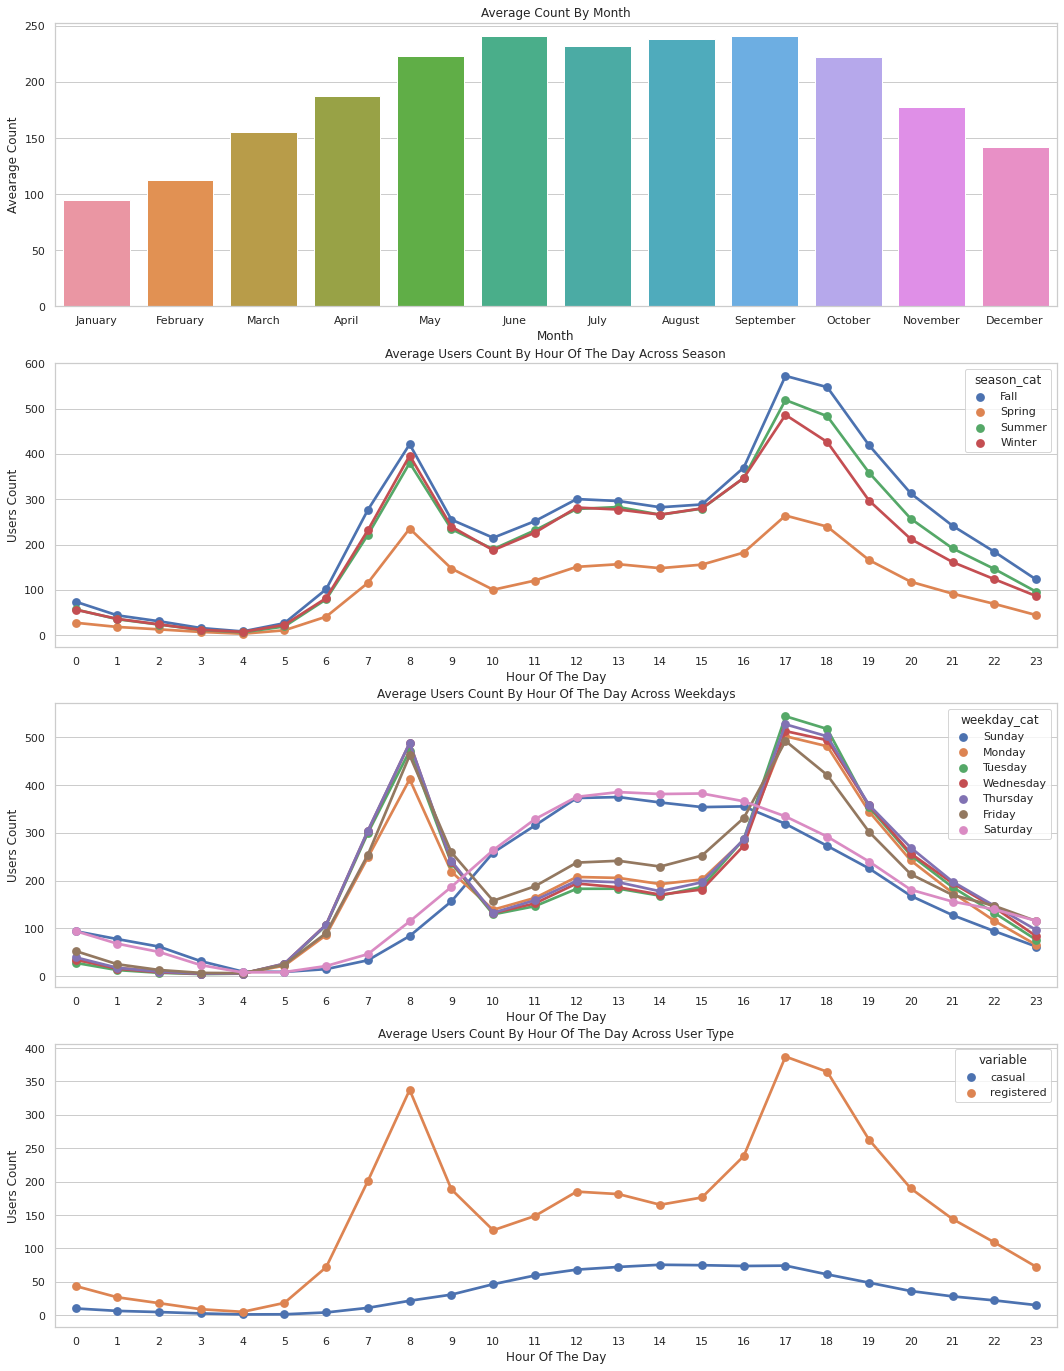

In [35]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(16,24)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(hours.groupby("month")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sns.barplot(data=monthSorted,x="month",y="cnt",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(hours.groupby(["hr","season_cat"],sort=True)["cnt"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["season_cat"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(hours.groupby(["hr","weekday_cat"],sort=True)["cnt"].mean()).reset_index()

sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["weekday_cat"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(hours[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.
On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

after experimenting, Vif technique is not useful now as dimensions are less, but lets keep it handy

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

Lets move to Modelling part

In [ ]:
%%shell
jupyter nbconvert --to html /content/Bike_Sharing_Data_Analysis.ipynb

[NbConvertApp] Converting notebook /content/Bike_Sharing_Data_Analysis.ipynb to html
[NbConvertApp] Writing 3386243 bytes to /content/Bike_Sharing_Data_Analysis.html
